# Banknote Authentication Clustering Project - Part 2:
# "Perhaps Some Featues are Better Left Out?"

This second part of this project will use Principal Component Analysis (PCA) dimensionality reduction algorithm to allow more than just 2 features of the UCI Bank Note dataset to be utilised. This will allow either 3 or 4 features to be reduced to 2 principal components, then k-means clustering can be applied to these. The purpose of this analysis is to investigate if the use of PCA to create the 2-principal components can be used to better represent the data, rather than just using the 2 features that were selected for clustering in the first notebook. 

Firstly, k-means will be used on the full dataset with 4 features to investigate if this can yield better classification results in 4-dimensional space.

Link to dataset: https://www.kaggle.com/datasets/ritesaluja/bank-note-authentication-uci-data

## 1. Import Required Libraries and EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler, minmax_scale
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

df = pd.read_csv('BankNote_Authentication.csv')
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## 1.1 Remove Outliers
Outliers detected in notebook 1 with the boxplot for features titled curtosis and entropy will be removed in the next cell.

In [2]:
# Give the features shorter names:
F1 = 'variance'
F2 = 'skewness'
F3 = 'curtosis'
F4 = 'entropy'

# Calculate the Z-score for each column and remove any rows that have values >= 3 standard deviations from the mean
def z_score(x):
    z = np.abs((x -x.mean())/x.std())
    return z
df_filtered = df[df.apply(lambda x: z_score(x) < 3).all(axis=1)]

print("{} Rows Removed During Filering for Outliers".format(len(df) - len(df_filtered)))
df_filtered.reset_index(inplace=True, drop=True)
df_filtered.tail()

36 Rows Removed During Filering for Outliers


,variance,skewness,curtosis,entropy,class
1331,-2.41000,3.74330,-0.40215,-1.29530,1
1332,0.40614,1.34920,-1.45010,-0.55949,1
1333,-1.38870,-4.87730,6.47740,0.34179,1
1334,-3.56370,-8.38270,12.39300,-1.28230,1
1335,-2.54190,-0.65804,2.68420,1.19520,1


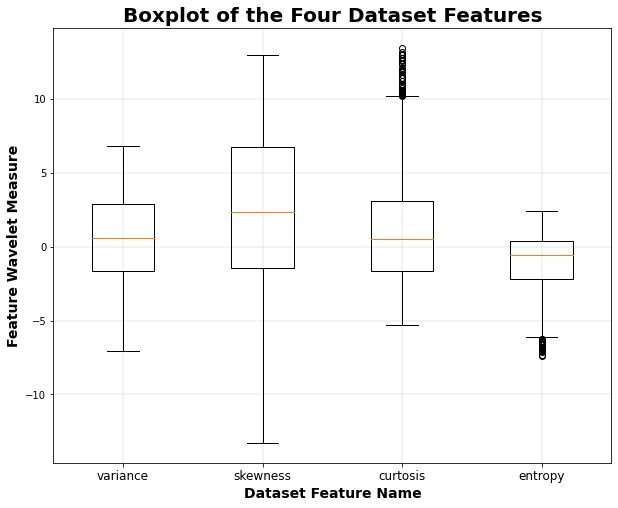

In [3]:
plt.figure(figsize=(10,8))
plt.boxplot(df_filtered.iloc[:,:-1]) # Dont plot the class column
plt.grid(linewidth=0.3)
plt.xticks([1,2,3,4], labels=df.columns[:-1], fontsize=12)
plt.title("Boxplot of the Four Dataset Features", fontweight='bold', fontsize=20)
plt.xlabel("Dataset Feature Name", fontweight='bold', fontsize=14)
plt.ylabel("Feature Wavelet Measure", fontweight='bold', fontsize=14)
plt.show()

From the boxplot above, it appears that there are still outliers in features F3 and F4. The threshold for outliers for this boxplot function must be lower than the 3 standard deviation threshold that was applied to the data. On that basis, the data will not be processed further for any more outliers.

In [4]:
scaled_data = minmax_scale(df_filtered.iloc[:,:-1], copy=True) # Dont scale the final 'class' column
scaled_df = pd.DataFrame(scaled_data, columns=(['F1','F2','F3','F4'])) # Convert numpy array to a dataframe
scaled_df.describe()

,F1,F2,F3,F4
count,1336.000000,1336.000000,1336.000000,1336.000000
mean,0.546903,0.584410,0.345493,0.639168
std,0.201338,0.212704,0.210600,0.203079
min,0.000000,0.000000,0.000000,0.000000
25%,0.387518,0.452544,0.193620,0.526294
50%,0.548945,0.595348,0.311490,0.694199
75%,0.715506,0.764079,0.446489,0.793202
max,1.000000,1.000000,1.000000,1.000000


## 2. K-Means With Higher Dimensional Space
The k-means algorithm will be used with the 4 dataset features, to investigate if this leads to better clustered data. This means that k-means will be applied in 4-dimensional space, so the output wont be visualised.


In [5]:
kmeans_result_4d = KMeans(n_clusters=2).fit(scaled_data[:,[0,1,2,3]]) # Use F1, F2, F3 & F4
clusters_4d = kmeans_result_4d.cluster_centers_
iterations_4d = kmeans_result_4d.n_iter_
kmeans_labels_4d = kmeans_result_4d.labels_

print("No. of Iterations:", iterations_4d)
print("K-Means Cluser Points = ","\n", clusters_4d)
k_means_class = pd.DataFrame(kmeans_labels_4d, columns=["kmeans"])

acc_score_4d = accuracy_score(y_true=df_filtered["class"], y_pred=kmeans_labels_4d, normalize=True, sample_weight=None)
print("Accuracy:", acc_score_4d.round(3))
k_means_class.value_counts()

No. of Iterations: 5
K-Means Cluser Points =  
 [[0.55444109 0.75568608 0.19647776 0.49875587]
 [0.53978102 0.42260839 0.48626632 0.77181438]]
Accuracy: 0.55


kmeans
1         686
0         650
dtype: int64

From the cell above, it can be seen that using all 4 features for clustering has not yielded a great result, as the accuracy is around 55%. This is not much better than a random guess that would achieve approximately a 50% accuracy as there are just 2 classes. Additionally, without visualising the reuslts it is difficult to identify which class has been assigned class 0 and which class has been assigned class 1 with the k-means algorithm.

## 3. PCA Dimensionality Reduction
In this section PCA will be used to extract 2 principal components from the 3 or 4 dataset features, to investigate if this yields a better clustering accuracy compared to the sole use of F1 and F2 in notebook 1. Before using PCA the data will need to be scaled so that its standard deviation is 1 and mean is 0. This will be implemented in the next cell.

## 3.1 Using All Four Features

In [6]:
scaler = StandardScaler()
X4 = scaler.fit_transform(df_filtered.loc[:,[F1,F2,F3,F4]])

In [7]:
X4_df = pd.DataFrame(X4, columns=['F1','F2','F3','F4'])
X4_df.describe()

,F1,F2,F3,F4
count,1.336000e+03,1.336000e+03,1.336000e+03,1.336000e+03
mean,4.510697e-16,2.748134e-16,-4.042841e-17,7.612008e-17
std,1.000374e+00,1.000374e+00,1.000374e+00,1.000374e+00
min,-2.717358e+00,-2.748562e+00,-1.641130e+00,-3.148566e+00
25%,-7.919227e-01,-6.201856e-01,-7.214155e-01,-5.560227e-01
50%,1.014796e-02,5.144331e-02,-1.615177e-01,2.710821e-01
75%,8.377285e-01,8.450040e-01,4.797411e-01,7.587737e-01
max,2.251275e+00,1.954575e+00,3.108978e+00,1.777469e+00


In [8]:
pca = PCA(n_components=2) # Reduce from 4 dimensions to 2 dimensions
principal_components = pca.fit_transform(X4)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.55083934 0.31112982]


By reducing the 4 features to 2 principal components with PCA, the total variance accounted for in the 2 principal components is 55 + 31 = ~86%.

In [9]:
X4_df = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])
X4_df.head()

,PC1,PC2
0,-1.453615,-1.209440
1,-1.637835,-1.162879
2,0.649301,-1.287059
3,-2.411223,-0.287174
4,1.292498,0.142029


In [10]:
def k_means_cluster_plot(title, x_label, y_label, x1, y1, x2, y2, centroids, subplot=False):
    if subplot == False:
        plot = plt.figure(figsize=(7,5))
    plt.scatter(x1, y1, alpha=0.5, s=25, c="black")
    plt.scatter(x2, y2, alpha=0.5, s=25, c="purple")
    plt.title(title, fontweight='bold', fontsize=16)
    plt.xlabel(x_label, fontweight='bold', fontsize=12)
    plt.ylabel(y_label, fontweight='bold', fontsize=12)
    black_patch = mpatches.Patch(color='black', label = "Class 0")
    purple_patch = mpatches.Patch(color='purple', label='Class 1')
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], alpha=0.7, s=1000, color='orange') # kmeans cluser centroids
        orange_patch = mpatches.Patch(color='orange', label='K-Means Cluster Centroids')
        plt.legend(handles=[black_patch, purple_patch, orange_patch], shadow="true", loc="lower right")
    else:
        plt.legend(handles=[black_patch, purple_patch], shadow="true", loc="lower right")
    return

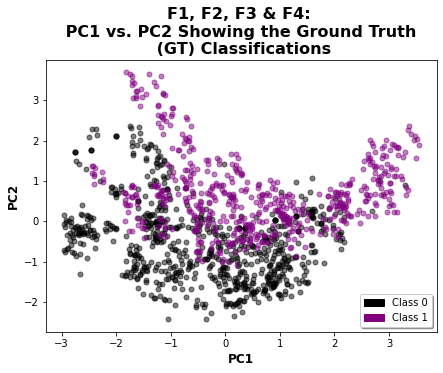

In [11]:
k_means_cluster_plot(title="F1, F2, F3 & F4: \n PC1 vs. PC2 Showing the Ground Truth \n (GT) Classifications", x_label="PC1", y_label="PC2", 
                             x1=X4_df["PC1"][df["class"]==0], 
                             y1=X4_df["PC2"][df["class"]==0],
                             x2=X4_df["PC1"][df["class"]==1],
                             y2=X4_df["PC2"][df["class"]==1], centroids=None)

From the plot above, its clear that the two principal components that were derived from the 4 dataset features have not resulted in two distinct clusters. This is expected as the classifications for features F3 and F4 have already been shown to have significant overlap between clusters, making it difficult for k-means to assign data to the correct cluster. Next k-means will be applied to this data to group it into 2 clusters.

In [12]:
kmeans_result_4f = KMeans(n_clusters=2).fit(X4_df) # Use PCA1 and PCA2
clusters_4f = kmeans_result_4f.cluster_centers_
iterations_4f = kmeans_result_4f.n_iter_
kmeans_labels_4f = kmeans_result_4f.labels_
kmeans_labels_4f_df = pd.DataFrame(kmeans_labels_4f, columns=["class"])
kmeans_labels_4f_df['class'].map({0:1,1:0}) # Match the data to the original classification of 0 or 1 

print("No. of Iterations:", iterations_4f)
print("K-Means Cluser Points = ","\n", clusters_4f)

acc_4f = accuracy_score(y_true=df_filtered["class"], y_pred=kmeans_labels_4f_df['class'], 
                        normalize=True, sample_weight=None).round(3)
print("Accuracy:", acc_4f)

No. of Iterations: 13
K-Means Cluser Points =  
 [[-1.26056185  0.28298396]
 [ 1.16261891 -0.26099672]]
Accuracy: 0.549


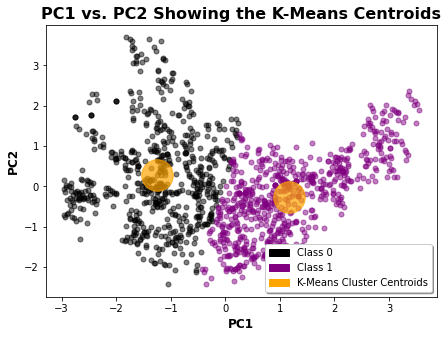

In [13]:
k_means_cluster_plot(title="PC1 vs. PC2 Showing the K-Means Centroids", x_label="PC1", y_label="PC2", 
                             x1=X4_df["PC1"][kmeans_labels_4f_df["class"]==0], 
                             y1=X4_df["PC2"][kmeans_labels_4f_df["class"]==0],
                             x2=X4_df["PC1"][kmeans_labels_4f_df["class"]==1],
                             y2=X4_df["PC2"][kmeans_labels_4f_df["class"]==1], centroids=clusters_4f)

The k-means clustering from the above two cells has not worked well here, as the accuracy score of ~55% is not much better than a random guess that would achieve a 50% accuracy. Next, Agglomerative hierarchial clustering will be teststed out with 4 clusters, where 2 clusters will each be grouped to form the two original classes of 0 and 1. This might achieve better results than k-means.

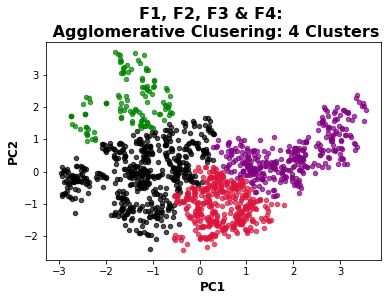

In [14]:
agg_4f = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_4f.fit(X4_df)

labels_4f = agg_4f.labels_
df_4f = pd.DataFrame(labels_4f, columns=["class"])

# Plot the 4 clusters:
colours = ['black','purple','crimson','green']
grouped_4f = df_4f['class'].map({0:0,1:1,2:0,3:1}) # Assign two clusters to class 0 and the other two to class 1

for i,j in enumerate(colours):
    plt.scatter(X4_df['PC1'][df_4f['class']==i], X4_df['PC2'][df_4f['class']==i], c = j, s=20, alpha=0.7)
plt.xlabel("PC1",fontweight='bold', fontsize=12)
plt.ylabel("PC2",fontweight='bold', fontsize=12)
plt.title("F1, F2, F3 & F4: \n Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16)    
plt.show()

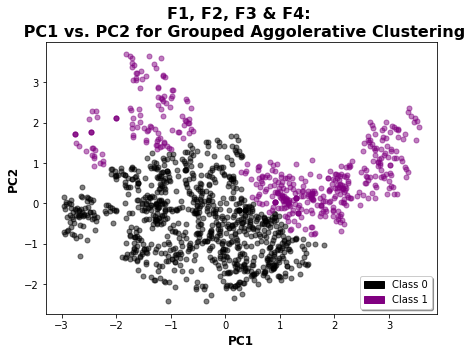

In [15]:
k_means_cluster_plot(title="F1, F2, F3 & F4: \n PC1 vs. PC2 for Grouped Aggolerative Clustering", 
                             x_label="PC1", y_label="PC2", 
                             x1=X4_df["PC1"][grouped_4f==0], 
                             y1=X4_df["PC2"][grouped_4f==0],
                             x2=X4_df["PC1"][grouped_4f==1],
                             y2=X4_df["PC2"][grouped_4f==1], centroids=None, subplot=False)

In [16]:
acc_4f_agg_grouped = accuracy_score(y_true=df_filtered["class"], y_pred=grouped_4f, 
                                    normalize=True, sample_weight=None).round(3)
print("acc_4f_agg_grouped:", acc_4f_agg_grouped)

acc_4f_agg_grouped: 0.708


From the output of the above cell it can be seen that he accuracy score has improved greatly by using agglomerative clusering and selecting the 2 sub clusters that will each make up the orignal two clusters, compared to k-means clustering alone.

## 3.1 Using Only 3 Features

### F1, F2 and F3

In [17]:
# PCA with the 3 selected features:
scaler = StandardScaler()
X3a = scaler.fit_transform(df_filtered.loc[:, [F1,F2,F3]]) # Features F1, F2 & F3
X3a_df = pd.DataFrame(X3a, columns=['F1','F2','F3'])
X3a_df.describe()

,F1,F2,F3
count,1.336000e+03,1.336000e+03,1.336000e+03
mean,4.510697e-16,2.748134e-16,-4.042841e-17
std,1.000374e+00,1.000374e+00,1.000374e+00
min,-2.717358e+00,-2.748562e+00,-1.641130e+00
25%,-7.919227e-01,-6.201856e-01,-7.214155e-01
50%,1.014796e-02,5.144331e-02,-1.615177e-01
75%,8.377285e-01,8.450040e-01,4.797411e-01
max,2.251275e+00,1.954575e+00,3.108978e+00


Explained Variance Ratio: [0.65127342 0.27363262]


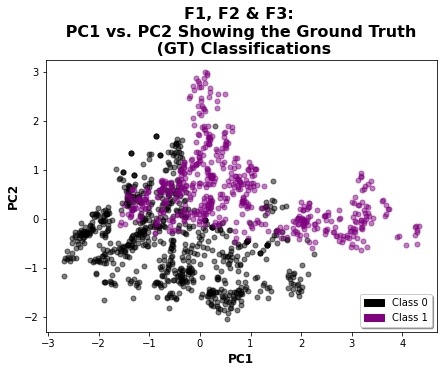

In [18]:
pca_3a = PCA(n_components=2) # Reduce from 3 dimensions to 2 dimensions
principal_components_3a = pca_3a.fit_transform(X3a_df)
print("Explained Variance Ratio:", pca_3a.explained_variance_ratio_)
X3a_pc = pd.DataFrame(principal_components_3a, columns = ["PC1", "PC2"])
# Plot the 2 principal components:
k_means_cluster_plot(title="F1, F2 & F3: \n PC1 vs. PC2 Showing the Ground Truth \n (GT) Classifications",
                             x_label="PC1", y_label="PC2", 
                             x1=X3a_pc["PC1"][df_filtered["class"]==0], 
                             y1=X3a_pc["PC2"][df_filtered["class"]==0],
                             x2=X3a_pc["PC1"][df_filtered["class"]==1],
                             y2=X3a_pc["PC2"][df_filtered["class"]==1], centroids=None)

By reducing the 3 selected features to 2 principal components with PCA, the total variance accounted for in the 2 principal components is 65 + 27 = ~92%. Next, these 2 principal components will be clustered into 2 groups using k-means.

In [33]:
kmeans_result_3a = KMeans(n_clusters=2).fit(X3a_pc)
clusters_3a = kmeans_result_3a.cluster_centers_
iterations_3a = kmeans_result_3a.n_iter_
kmeans_labels_3a = kmeans_result_3a.labels_

print("No. of Iterations:", iterations_3a)
print("K-Means Cluser Points = ","\n", clusters_3a)
kmeans_3a = pd.DataFrame(kmeans_labels_3a, columns=["class"])
kmeans_3a['class'].map({0:1,1:0}) # Swap over the classifications to better align with the ground truth classifications

acc_3a = accuracy_score(y_true=df_filtered["class"], y_pred=kmeans_3a, normalize=True, sample_weight=None).round(3)
print("Accuracy:", acc_3a)
kmeans_3a.value_counts()

No. of Iterations: 7
K-Means Cluser Points =  
 [[-0.75853425  0.18403927]
 [ 1.57649283 -0.38249635]]
Accuracy: 0.597


class
0        902
1        434
dtype: int64

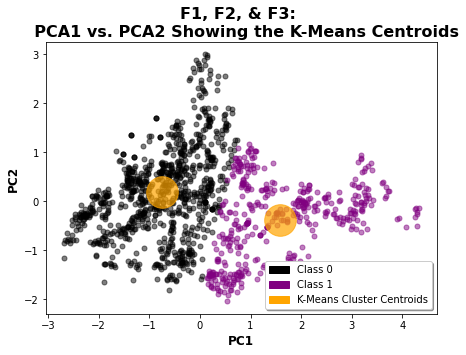

In [34]:
# Plot K-Means Cluser points on Graph:
k_means_cluster_plot(title="F1, F2, & F3: \n  PCA1 vs. PCA2 Showing the K-Means Centroids", x_label="PC1", y_label="PC2", 
                             x1=X3a_pc["PC1"][kmeans_3a["class"]==0], 
                             y1=X3a_pc["PC2"][kmeans_3a["class"]==0],
                             x2=X3a_pc["PC1"][kmeans_3a["class"]==1],
                             y2=X3a_pc["PC2"][kmeans_3a["class"]==1], centroids=clusters_3a)

K-means clustering has not worked well on the data as the clusters do not align very well with the ground truth labels. Next, agglomerative clustering will be applied to cluster the data into 4 groups that will be paired off to yield the 2 overall clusters. This should yield better results.

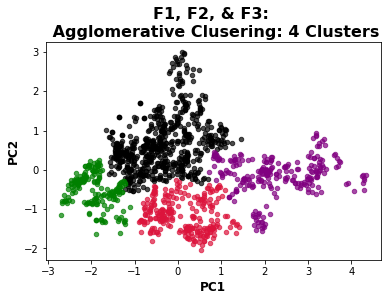

acc_3fa: 0.764


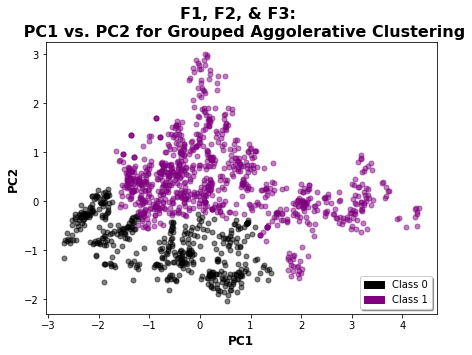

In [21]:
agg_3fa = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_3fa.fit(X3a_pc)

class_3fa = pd.DataFrame(agg_3fa.labels_, columns=['class'])

grouped_3fa = class_3fa['class'].map({0:1,1:1,2:0,3:0})

for i,j in enumerate(colours):
        plt.scatter(X3a_pc['PC1'][class_3fa['class']==i], X3a_pc['PC2'][class_3fa['class']==i], c=j, s=20, alpha=0.7)
plt.xlabel("PC1",fontweight='bold', fontsize=12)
plt.ylabel("PC2",fontweight='bold', fontsize=12)
plt.title("F1, F2, & F3: \n Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16) 
plt.show()

acc_3fa = accuracy_score(y_true=df_filtered["class"], y_pred=grouped_3fa, normalize=True, sample_weight=None).round(3)
print("acc_3fa:", acc_3fa)

k_means_cluster_plot(title="F1, F2, & F3: \n PC1 vs. PC2 for Grouped Aggolerative Clustering", x_label="PC1", y_label="PC2", 
                             x1=X3a_pc["PC1"][grouped_3fa==0], 
                             y1=X3a_pc["PC2"][grouped_3fa==0],
                             x2=X3a_pc["PC1"][grouped_3fa==1],
                             y2=X3a_pc["PC2"][grouped_3fa==1], centroids=None, subplot=False)

From the output of the above cell it can be seen that the accuracy score has improved to ~76% compared to k-means.

### F1, F2 and F4

In [22]:
scaler = StandardScaler()
X3b = scaler.fit_transform(df_filtered.loc[:, [F1,F2,F4]]) # Features F1, F2 & F4
X3b_df = pd.DataFrame(X3b, columns=['F1','F2','F4'])
X3b_df.describe()

,F1,F2,F4
count,1.336000e+03,1.336000e+03,1.336000e+03
mean,4.510697e-16,2.748134e-16,7.612008e-17
std,1.000374e+00,1.000374e+00,1.000374e+00
min,-2.717358e+00,-2.748562e+00,-3.148566e+00
25%,-7.919227e-01,-6.201856e-01,-5.560227e-01
50%,1.014796e-02,5.144331e-02,2.710821e-01
75%,8.377285e-01,8.450040e-01,7.587737e-01
max,2.251275e+00,1.954575e+00,1.777469e+00


Explained Variance Ratio: [0.51816384 0.38906092]


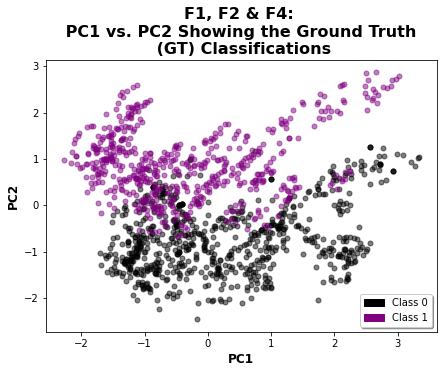

In [23]:
pca_3b = PCA(n_components=2) # Reduce from 3 dimensions to 2 dimensions
principal_components_3b = pca_3b.fit_transform(X3b_df)
print("Explained Variance Ratio:", pca_3b.explained_variance_ratio_)
X3b_pc = pd.DataFrame(principal_components_3b, columns = ["PC1", "PC2"])
# Plot the 2 principal components:
k_means_cluster_plot(title="F1, F2 & F4: \n PC1 vs. PC2 Showing the Ground Truth \n (GT) Classifications", 
                             x_label="PC1", y_label="PC2", 
                             x1=X3b_pc["PC1"][df_filtered["class"]==0], 
                             y1=X3b_pc["PC2"][df_filtered["class"]==0],
                             x2=X3b_pc["PC1"][df_filtered["class"]==1],
                             y2=X3b_pc["PC2"][df_filtered["class"]==1], centroids=None)

By reducing the 3 selected features to 2 principal components with PCA, the total variance accounted for in the 2 principal components is 51 + 39 = ~90%. Next, these 2 principal components will be clustered into 2 groups using k-means.

In [24]:
kmeans_result_3b = KMeans(n_clusters=2).fit(X3b_pc)
clusters_3b = kmeans_result_3b.cluster_centers_
iterations_3b = kmeans_result_3b.n_iter_
kmeans_labels_3b = kmeans_result_3b.labels_

print("No. of Iterations:", iterations_3b)
print("K-Means Cluser Points = ","\n", clusters_3b)
kmeans_3b = pd.DataFrame(kmeans_labels_3b, columns=["class"])
kmeans_3b['class'].map({0:1,1:0}) # Swap the classifications to align better with the ground truth labels

acc_3b = accuracy_score(y_true=df_filtered["class"], y_pred=kmeans_3b, normalize=True, sample_weight=None).round(3)
print("Accuracy:", acc_3b)
kmeans_3b.value_counts()

No. of Iterations: 7
K-Means Cluser Points =  
 [[ 1.38297009  0.02338173]
 [-0.82713522 -0.01398429]]
Accuracy: 0.554


class
1        837
0        499
dtype: int64

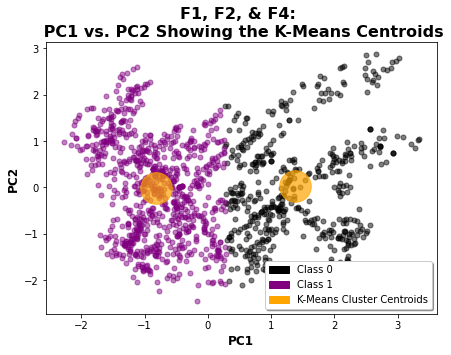

In [25]:
# Plot K-Means Cluser points on Graph:
k_means_cluster_plot(title="F1, F2, & F4: \n PC1 vs. PC2 Showing the K-Means Centroids", x_label="PC1", y_label="PC2", 
                             x1=X3b_pc["PC1"][kmeans_3b["class"]==0], 
                             y1=X3b_pc["PC2"][kmeans_3b["class"]==0],
                             x2=X3b_pc["PC1"][kmeans_3b["class"]==1],
                             y2=X3b_pc["PC2"][kmeans_3b["class"]==1], centroids=clusters_3b)

As previously, k-means clustering has not worked well on the data as the clusters do not align very well with the ground truth labels. Next, agglomerative clustering will be applied to cluster the data into 4 groups that will be paired off to yield the 2 overall clusters. This should yield better results.

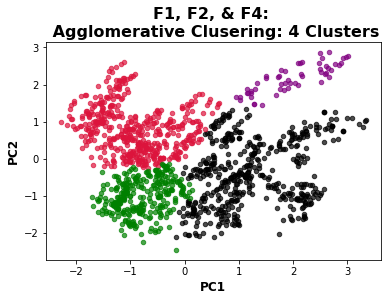

acc_3fb: 0.847


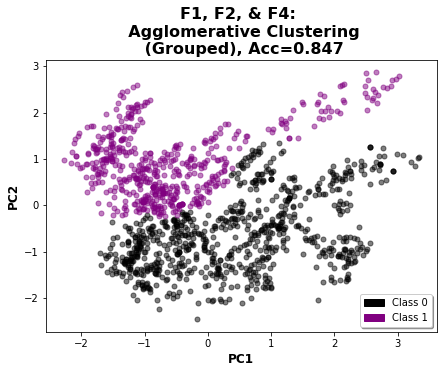

In [26]:
agg_3b = AgglomerativeClustering(n_clusters=4, linkage='average')
agg_3b.fit(X3b_pc)
class_3fb = pd.DataFrame(agg_3b.labels_, columns=['class'])

for i,j in enumerate(colours):
    plt.scatter(X3b_pc['PC1'][class_3fb['class']==i], X3b_pc['PC2'][class_3fb['class']==i], c = j, s=20, alpha=0.7)
plt.xlabel("PC1",fontweight='bold', fontsize=12)
plt.ylabel("PC2",fontweight='bold', fontsize=12)
plt.title("F1, F2, & F4: \n Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16) 
plt.show()

grouped_3fb = class_3fb['class'].map({0:0,1:1,2:1,3:0}) # Group the 4 clusers into 2 main classes
acc_3fb = accuracy_score(y_true=df_filtered["class"], y_pred=grouped_3fb, normalize=True, sample_weight=None).round(3)
print("acc_3fb:", acc_3fb)

k_means_cluster_plot(title="F1, F2, & F4: \n  Agglomerative Clustering \n (Grouped), Acc={}".format(acc_3fb), 
                             x_label="PC1", y_label="PC2", 
                             x1=X3b_pc["PC1"][grouped_3fb==0], 
                             y1=X3b_pc["PC2"][grouped_3fb==0],
                             x2=X3b_pc["PC1"][grouped_3fb==1],
                             y2=X3b_pc["PC2"][grouped_3fb==1], centroids=None)

From the output of the above cell, it can be seen that the highest accuracy of ~85% has been achieved in this notebook through the use of F1, F2 and F4, PCA dimensionality reduction and agglomerative clustering.

# 4. Summary of Results

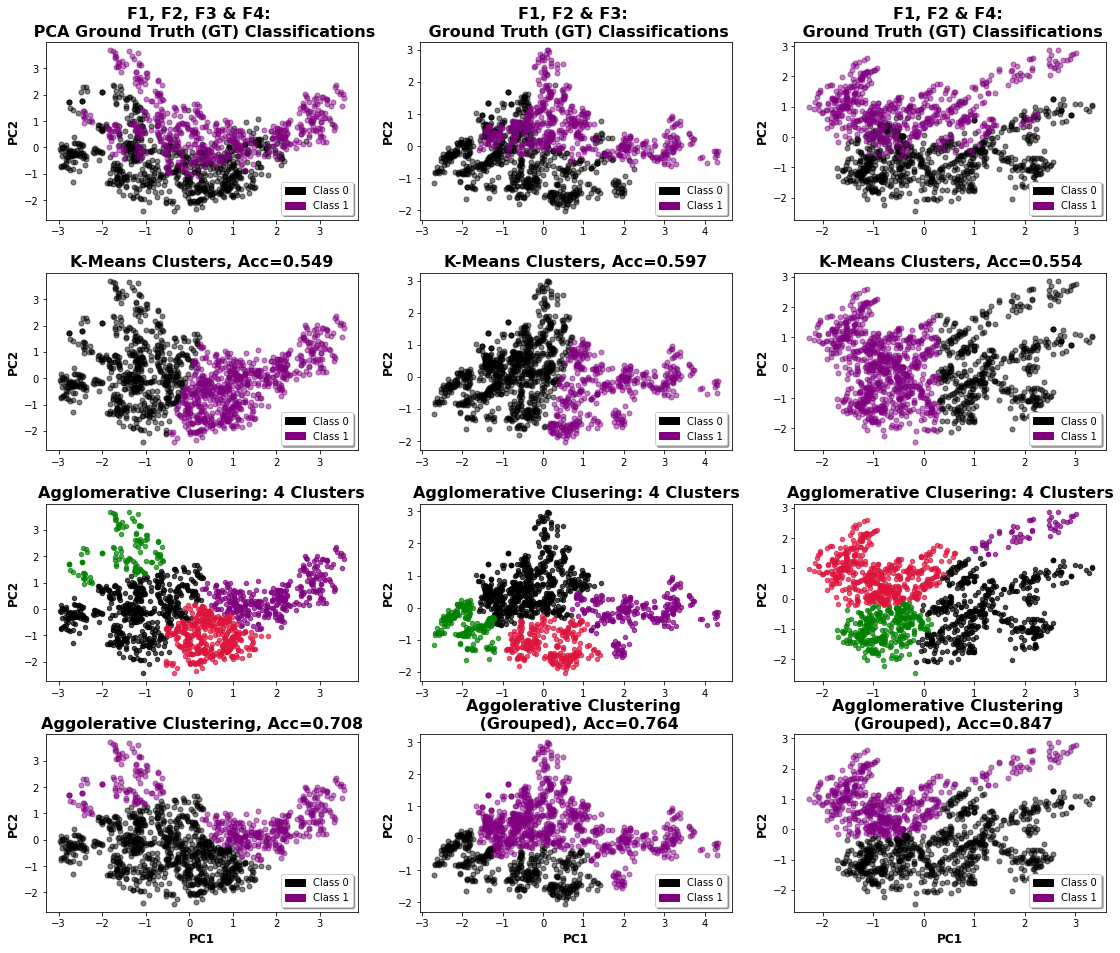

In [35]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(19, 16), sharex=True)
fig.subplots_adjust(hspace=0.3)
plt.subplot(nrows,ncols,1) 
k_means_cluster_plot(title="F1, F2, F3 & F4: \n PCA Ground Truth (GT) Classifications", x_label="", y_label="PC2", 
                             x1=X4_df["PC1"][df["class"]==0], 
                             y1=X4_df["PC2"][df["class"]==0],
                             x2=X4_df["PC1"][df["class"]==1],
                             y2=X4_df["PC2"][df["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,4)
k_means_cluster_plot(title="K-Means Clusters, Acc={}".format(acc_4f), x_label="", y_label="PC2", 
                             x1=X4_df["PC1"][kmeans_labels_4f_df["class"]==0], 
                             y1=X4_df["PC2"][kmeans_labels_4f_df["class"]==0],
                             x2=X4_df["PC1"][kmeans_labels_4f_df["class"]==1],
                             y2=X4_df["PC2"][kmeans_labels_4f_df["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,7)
for i,j in enumerate(colours):
    plt.scatter(X4_df['PC1'][df_4f['class']==i], X4_df['PC2'][df_4f['class']==i], c = j, s=20, alpha=0.7)
plt.ylabel("PC2",fontweight='bold', fontsize=12)
plt.title("Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16)

plt.subplot(nrows,ncols,10)
k_means_cluster_plot(title="Aggolerative Clustering, Acc={}".format(acc_4f_agg_grouped),
                             x_label="PC1", y_label="PC2", 
                             x1=X4_df["PC1"][grouped_4f==0], 
                             y1=X4_df["PC2"][grouped_4f==0],
                             x2=X4_df["PC1"][grouped_4f==1],
                             y2=X4_df["PC2"][grouped_4f==1], centroids=None, subplot=True)
# F1, F2 & F3 Plots: ----------------------------------------------------------------------------------------------------
plt.subplot(nrows,ncols,2)
k_means_cluster_plot(title="F1, F2 & F3: \n Ground Truth (GT) Classifications", x_label="", y_label="PC2", 
                             x1=X3a_pc["PC1"][df_filtered["class"]==0], 
                             y1=X3a_pc["PC2"][df_filtered["class"]==0],
                             x2=X3a_pc["PC1"][df_filtered["class"]==1],
                             y2=X3a_pc["PC2"][df_filtered["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,5)
k_means_cluster_plot(title="K-Means Clusters, Acc={}".format(acc_3a), x_label="", y_label="PC2", 
                             x1=X3a_pc["PC1"][kmeans_3a["class"]==0], 
                             y1=X3a_pc["PC2"][kmeans_3a["class"]==0],
                             x2=X3a_pc["PC1"][kmeans_3a["class"]==1],
                             y2=X3a_pc["PC2"][kmeans_3a["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,8)
for i,j in enumerate(colours):
        plt.scatter(X3a_pc['PC1'][class_3fa['class']==i], X3a_pc['PC2'][class_3fa['class']==i], c=j, s=20, alpha=0.7)
plt.ylabel("PC2",fontweight='bold', fontsize=12)
plt.title("Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16)
plt.subplot(nrows,ncols,11)
k_means_cluster_plot(title="Aggolerative Clustering \n (Grouped), Acc={}".format(acc_3fa), x_label="PC1", y_label="PC2", 
                             x1=X3a_pc["PC1"][grouped_3fa==0], 
                             y1=X3a_pc["PC2"][grouped_3fa==0],
                             x2=X3a_pc["PC1"][grouped_3fa==1],
                             y2=X3a_pc["PC2"][grouped_3fa==1], centroids=None, subplot=True)
# F1, F2 & F4 Plots: ----------------------------------------------------------------------------------------------------
plt.subplot(nrows,ncols,3)
k_means_cluster_plot(title="F1, F2 & F4: \n Ground Truth (GT) Classifications", x_label="", y_label="PC2", 
                             x1=X3b_pc["PC1"][df_filtered["class"]==0], 
                             y1=X3b_pc["PC2"][df_filtered["class"]==0],
                             x2=X3b_pc["PC1"][df_filtered["class"]==1],
                             y2=X3b_pc["PC2"][df_filtered["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,6)
k_means_cluster_plot(title="K-Means Clusters, Acc={}".format(acc_3b), x_label="", y_label="PC2", 
                             x1=X3b_pc["PC1"][kmeans_3b["class"]==0], 
                             y1=X3b_pc["PC2"][kmeans_3b["class"]==0],
                             x2=X3b_pc["PC1"][kmeans_3b["class"]==1],
                             y2=X3b_pc["PC2"][kmeans_3b["class"]==1], centroids=None, subplot=True)
plt.subplot(nrows,ncols,9)
for i,j in enumerate(colours):
    plt.scatter(X3b_pc['PC1'][class_3fb['class']==i], X3b_pc['PC2'][class_3fb['class']==i], c = j, s=20, alpha=0.7)
plt.title("Agglomerative Clusering: 4 Clusters", fontweight='bold',fontsize=16)
plt.ylabel("PC2",fontweight='bold', fontsize=12)

plt.subplot(nrows,ncols,12)
k_means_cluster_plot(title="Agglomerative Clustering \n (Grouped), Acc={}".format(acc_3fb), x_label="PC1", y_label="PC2", 
                             x1=X3b_pc["PC1"][grouped_3fb==0], 
                             y1=X3b_pc["PC2"][grouped_3fb==0],
                             x2=X3b_pc["PC1"][grouped_3fb==1],
                             y2=X3b_pc["PC2"][grouped_3fb==1], centroids=None, subplot=True)
plt.savefig('Notebook 2 - Results Summary - Plots')
plt.show()

# 5. Conclusions and Further Work
From the results summary presented in section 4, a clear comparison can be made between the feature selection and the effect that this has on the clustering effectiveness, when comparing to the ground truth labels. From inspection of this plot, the following conclusions can be made:

**(1)** The k-means clustering algorithm has not performed well on any of the feature combinations that were used within this notebook. This was expected, as the PCA reduced the multiple features to 2 dimensions and the GT classifications were not present in distinct groups in any case. 

**(2)** Agglomerative clustering with 4 clusters that were manually assigned to two overall clusters resulted in significantly better results than k-means alone. 

**(3)** The use of all 4 features had the worst performance in both clustering tasks.

**(4)** The use of features F1, F2 and F4 had the best results in both clustering tasks. This resulted in ~84.7% accuracy but this is still not better than the 87% that was acheieved through the use of just F1 and F2 in notebook 1.

Therefore in conclusion, it seems that more features are not better and that some features are better left out, if permitted. This also highlights feature selection as an important and neccesary task to extract the best clustering results from a given dataset. 

For further work, this methodolgy could be applied to other datasets and the results could be compared to those presented in this notebook.